# Ch.17 Regression for Prediction

## Marthon Speed Change

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
tables = pd.read_html(url)
len(tables)

6

In [16]:
table = tables[0]
table.tail(3)

,Time,Name,Nationality,Date,Event/Place,Source,Notes
49,2:01:39,Eliud Kipchoge,Kenya,"September 16, 2018",Berlin Marathon,IAAF[88],NaN
50,2:01:09,Eliud Kipchoge,Kenya,"September 25, 2022",Berlin Marathon,World Athletics[89],NaN
51,2:00:35,Kelvin Kiptum,Kenya,"October 8, 2023",Chicago Marathon,World Athletics[90],First man to break 2:01:00 in a record-eligibl...


In [17]:
table['date'] = pd.to_datetime(table['Date'], errors='coerce')
table['date'].head()

0   1908-07-24
1   1909-01-01
2   1909-02-12
3   1909-05-08
4          NaT
Name: date, dtype: datetime64[ns]

In [18]:
table['time'] = pd.to_timedelta(table['Time'])
mph = True 
if mph:
    table['y'] = 26.2 / table['time'].dt.total_seconds() * 3600  # Convert to miles per hour
else: # Convert to kilometers per hour
    table['y'] = 42.195 / table['time'].dt.total_seconds() * 3600  # 42.195 km is the marathon distance
table['y'].head()

0    8.967143
1    9.099504
2    9.419942
3    9.465508
4    9.672854
Name: y, dtype: float64

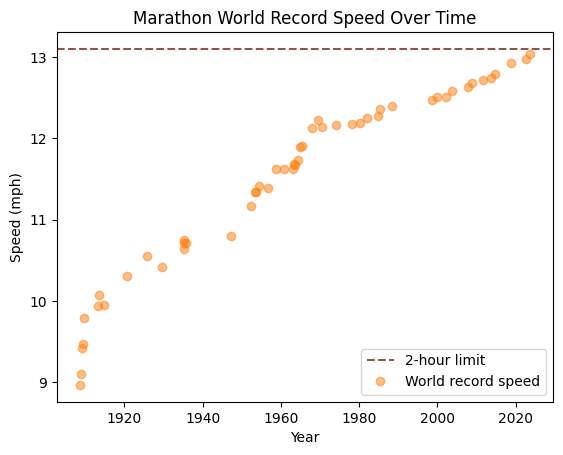

In [19]:
if mph:
    two_hour_limit = 26.2 / 7200 * 3600  # 2 hours in mph
else:
    two_hour_limit = 42.195 / 7200 * 3600

def plot_speeds(df):
    """Plot marathon world record speed as a function of time.
    
    df: DataFrame with date and mph
    """
    plt.axhline(two_hour_limit, color='C5', ls='--', label='2-hour limit')
    plt.plot(df['date'], df['y'], 'o', 
             label='World record speed', 
             color='C1', alpha=0.5)
    plt.xlabel('Year')
    plt.ylabel('Speed (km/h)' if not mph else 'Speed (mph)')
    plt.title('Marathon World Record Speed Over Time')
    plt.legend()
#
plot_speeds(table)

In [20]:
recent = table['date'] > pd.to_datetime('1970')
data = table.loc[recent].copy()
data.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes,date,time,y
32,2:09:28.8,Ron Hill,United Kingdom,"July 23, 1970","Edinburgh Commonwealth Games, Scotland",ARRS[19],NaN,1970-07-23,0 days 02:09:28.800000,12.140871
33,2:09:12,Ian Thompson,United Kingdom,"January 31, 1974","Christchurch Commonwealth Games, New Zealand",ARRS[19],NaN,1974-01-31,0 days 02:09:12,12.167183
34,2:09:05.6,Shigeru So,Japan,"February 5, 1978",Beppu-Ōita Marathon,ARRS[19],NaN,1978-02-05,0 days 02:09:05.600000,12.177236
35,2:09:01,Gerard Nijboer,Netherlands,"April 26, 1980",Amsterdam Marathon,ARRS[19],NaN,1980-04-26,0 days 02:09:01,12.184472
36,2:08:18,Robert De Castella,Australia,"December 6, 1981",Fukuoka Marathon,"IAAF,[52] ARRS[19]",NaN,1981-12-06,0 days 02:08:18,12.252533


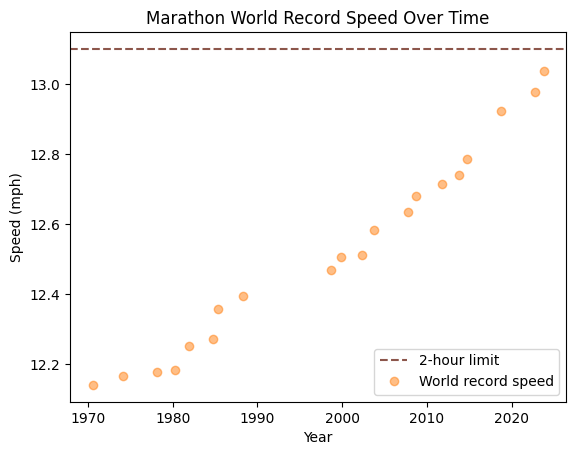

In [21]:
plot_speeds(data)

In [22]:
offset = pd.to_datetime('1995') # approximate midpoint of the data
timedelta = data['date'] - offset
data['x'] = timedelta.dt.total_seconds() / (365.25 * 24 * 3600)  # Convert to years
data['x'].describe()        

count    20.000000
mean      3.491718
std      16.863989
min     -24.443532
25%     -10.914442
50%       6.046543
75%      17.234086
max      28.766598
Name: x, dtype: float64

In [23]:
import statsmodels.formula.api as smf
formula = 'y ~ x'
model = smf.ols(formula, data=data).fit()
print(model.params)
print(model.bse)
print("resid.std: ", model.resid.std())

Intercept    12.467888
x             0.016466
dtype: float64
Intercept    0.011560
x            0.000688
dtype: float64
resid.std:  0.049218783293286106


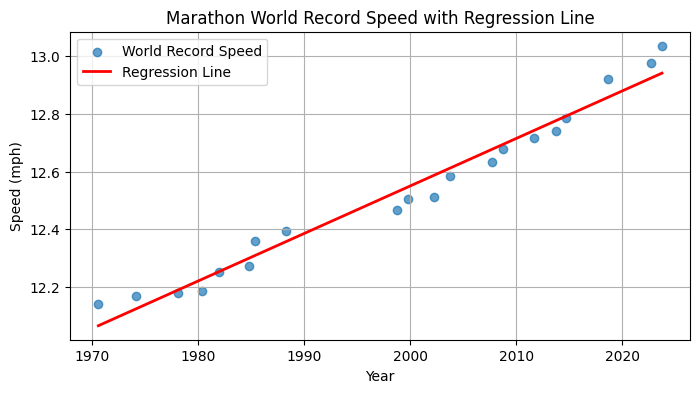

In [24]:
plt.figure(figsize=(8,4))
plt.scatter(data['date'], data['y'], alpha=0.7, label='World Record Speed')
plt.plot(data['date'], model.fittedvalues, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Year')
plt.ylabel('Speed (mph)')
plt.title('Marathon World Record Speed with Regression Line')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
future_years = np.arange(2020, 2031)
future_years = pd.to_datetime(future_years, format='%Y')  # Convert to datetime
future_years - offset  # Center around the same offset

TimedeltaIndex([ '9131 days',  '9497 days',  '9862 days', '10227 days',
                '10592 days', '10958 days', '11323 days', '11688 days',
                '12053 days', '12419 days', '12784 days'],
               dtype='timedelta64[ns]', freq=None)

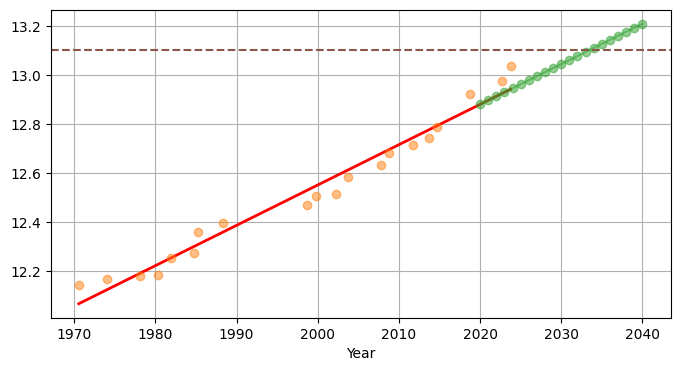

In [26]:
# prediction
# In what year will the marathon world record be under 2 hours?
future_years = np.arange(2020, 2041)
future_years = pd.to_datetime(future_years, format='%Y')  # Convert to datetime
future_x = (future_years - pd.to_datetime('1995')).total_seconds() / (365.25 * 24 * 3600)  # Convert to years
future_y = future_x * model.params['x'] + model.params['Intercept']
two_hour_limit = 26.2 / 7200 * 3600  #
plt.figure(figsize=(8, 4))
plt.plot(data['date'], model.fittedvalues, color='red', linewidth=2, label='Regression Line')
plt.plot(future_years, future_y, '-o', label='Predicted Speed', color='C2', alpha=0.5)
plt.plot(data['date'], data['y'], 'o', label='Observed Speed', color='C1', alpha=0.5)
plt.axhline(y=two_hour_limit, color='C5', ls='--', label='2-hour limit')
plt.xlabel('Year'); plt.grid(True);

In [27]:
future_df = pd.DataFrame({
    'date': future_years,
    'y': future_y
})
future_df[future_df.y > two_hour_limit]

,date,y
14,2034-01-01,13.110065
15,2035-01-01,13.126520
16,2036-01-01,13.142975
17,2037-01-01,13.159474
18,2038-01-01,13.175929
19,2039-01-01,13.192383
20,2040-01-01,13.208838


#### Bayesian Analysis

In [28]:
gamma_mean = model.resid.std()  # Standard deviation of residuals
gamma_std = gamma_mean / 5  # Adjusted standard deviation
gamma_shape = (gamma_mean / gamma_std) ** 2
gamma_rate = gamma_mean / gamma_std ** 2
print(f"Gamma prior parameters: shape = {gamma_shape:.3f}, rate = {gamma_rate:.3f} for mean= {gamma_mean:.3f}, std = {gamma_std:.3f}")

b_mean = model.params['Intercept']  # Intercept mean
b_std = b_mean / 5  # Adjusted standard deviation for intercept
print(f"Prior for intercept: mean = {b_mean:.3f}, std = {b_std:.3f}")

a_mean = model.params['x']  # Slope mean
a_std = a_mean / 5  # Adjusted standard deviation for slope
print(f"Prior for slope: mean = {a_mean:.3f}, std = {a_std:.3f}")

# Write Stan model to file
stan_code = """
data {
    real<lower=0> gamma_shape;  // shape parameter for Gamma prior
    real<lower=0> gamma_rate;   // rate parameter for Gamma prior
    real b_mean;  // prior mean for intercept
    real b_std;   // prior stddev for intercept
    real a_mean;  // prior mean for slope
    real a_std;   // prior stddev for slope

    int<lower=0> N;         // number of data points
    vector[N] x;            // predictor
    vector[N] y;            // response
}
parameters {
    real a;                 // slope
    real b;                 // intercept
    real<lower=0> sigma;    // noise stddev
}
model {
    a ~ normal(a_mean, a_std);  // prior for slope
    b ~ normal(b_mean, b_std);  // prior for intercept
    sigma ~ gamma(gamma_shape, gamma_rate);  // prior for noise stddev
    y ~ normal(a * x + b, sigma);
}
"""
print(stan_code)
# Let's use the same Stan code as before, but with different priors for sigma
with open('marathon_regression.stan', 'w') as f:
    f.write(stan_code)

Gamma prior parameters: shape = 25.000, rate = 507.936 for mean= 0.049, std = 0.010
Prior for intercept: mean = 12.468, std = 2.494
Prior for slope: mean = 0.016, std = 0.003

data {
    real<lower=0> gamma_shape;  // shape parameter for Gamma prior
    real<lower=0> gamma_rate;   // rate parameter for Gamma prior
    real b_mean;  // prior mean for intercept
    real b_std;   // prior stddev for intercept
    real a_mean;  // prior mean for slope
    real a_std;   // prior stddev for slope

    int<lower=0> N;         // number of data points
    vector[N] x;            // predictor
    vector[N] y;            // response
}
parameters {
    real a;                 // slope
    real b;                 // intercept
    real<lower=0> sigma;    // noise stddev
}
model {
    a ~ normal(a_mean, a_std);  // prior for slope
    b ~ normal(b_mean, b_std);  // prior for intercept
    sigma ~ gamma(gamma_shape, gamma_rate);  // prior for noise stddev
    y ~ normal(a * x + b, sigma);
}



In [29]:
from cmdstanpy import CmdStanModel

# Prepare data for Stan
stan_data = {
    'gamma_shape': float(gamma_shape),
    'gamma_rate': float(gamma_rate),
    'b_mean': b_mean,
    'b_std': b_std,
    'a_mean': a_mean,
    'a_std': a_std,
    'N': len(data),
    'x': data['x'].values.astype(float),
    'y': data['y'].values.astype(float)
}

# Compile Stan model (if not already compiled)
model = CmdStanModel(stan_file='marathon_regression.stan')

# Run MCMC sampling
fit = model.sample(data=stan_data, chains=4, iter_sampling=1000, iter_warmup=500, seed=42)

# Extract posterior samples as a pandas DataFrame
samples = fit.draws_pd()
print(samples.head())

C:\Users\yongd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
09:25:08 - cmdstanpy - INFO - compiling stan file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\marathon_regression.stan to exe file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\marathon_regression.exe
09:25:17 - cmdstanpy - INFO - compiled model executable: C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\marathon_regression.exe
09:25:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 


09:25:19 - cmdstanpy - INFO - CmdStan done processing.
09:25:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'marathon_regression.stan', line 22, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'marathon_regression.stan', line 22, column 4 to column 43)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'marathon_regression.stan', line 22, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'marathon_regression.stan', line 22, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'marathon_regression.stan', line 22, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'marathon_regression.stan', line 22, column 4 to column 43)
	Exception: gamma_lpdf: Random variabl


   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -50.5400       0.975896     0.12639          4.0   
1      1.0     2.0     2.0 -49.8962       0.993941     0.12639          3.0   
2      1.0     3.0     3.0 -50.5827       0.907623     0.12639          4.0   
3      1.0     4.0     4.0 -50.0314       0.998948     0.12639          3.0   
4      1.0     5.0     5.0 -50.8427       0.959172     0.12639          3.0   

   n_leapfrog__  divergent__  energy__         a        b     sigma  
0          15.0          0.0   51.4253  0.016285  12.4537  0.048159  
1          15.0          0.0   52.0616  0.016040  12.4747  0.047942  
2          23.0          0.0   51.5759  0.017335  12.4702  0.048254  
3          15.0          0.0   50.6847  0.015827  12.4702  0.049320  
4          15.0          0.0   51.3298  0.017346  12.4735  0.052882  


In [30]:
print(samples[['a', 'b', 'sigma', 'lp__']].head())

          a        b     sigma     lp__
0  0.016285  12.4537  0.048159 -50.5400
1  0.016040  12.4747  0.047942 -49.8962
2  0.017335  12.4702  0.048254 -50.5827
3  0.015827  12.4702  0.049320 -50.0314
4  0.017346  12.4735  0.052882 -50.8427


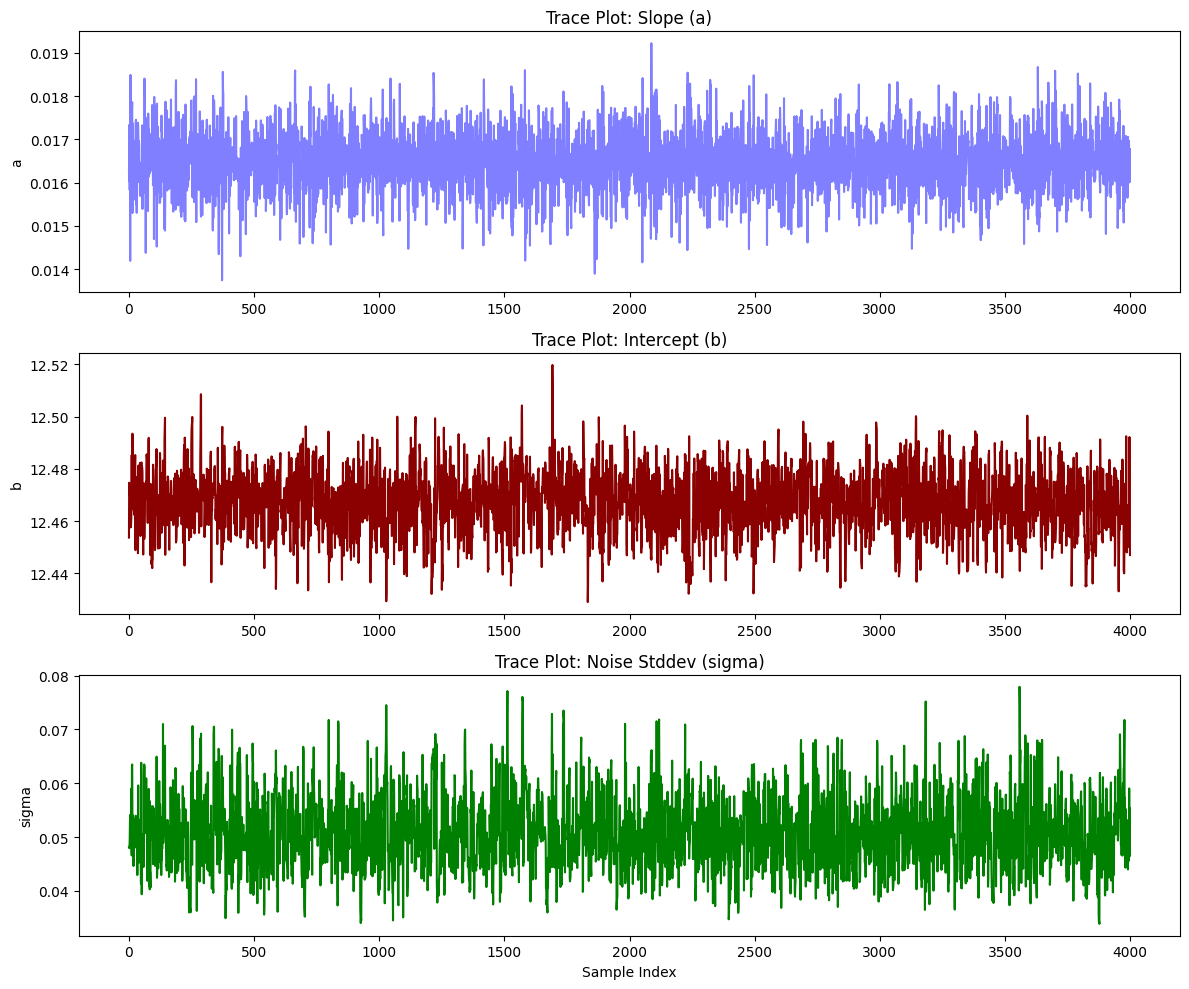

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=False)

axes[0].plot(samples['a'], color='blue', alpha=0.5)
axes[0].set_title('Trace Plot: Slope (a)')
axes[0].set_ylabel('a')

axes[1].plot(samples['b'], color='darkred')
axes[1].set_title('Trace Plot: Intercept (b)')
axes[1].set_ylabel('b')

axes[2].plot(samples['sigma'], color='green')
axes[2].set_title('Trace Plot: Noise Stddev (sigma)')
axes[2].set_ylabel('sigma')
axes[2].set_xlabel('Sample Index')

plt.tight_layout()
plt.show()

In [32]:
 # Summary statistics for parameters
print(samples[['a', 'b', 'sigma']].describe()) 

ci_a = np.percentile(samples['a'], [5, 95])
ci_b = np.percentile(samples['b'], [5, 95])
ci_sigma = np.percentile(samples['sigma'], [5, 95])
print(f"90% credible interval for a: {ci_a[0]:.3f} to {ci_a[1]:.3f}")
print(f"90% credible interval for b: {ci_b[0]:.3f} to {ci_b[1]:.3f}")
print(f"90% credible interval for sigma: {ci_sigma[0]:.3f} to {ci_sigma[1]:.3f}")

                 a            b        sigma
count  4000.000000  4000.000000  4000.000000
mean      0.016485    12.467371     0.050866
std       0.000697     0.012111     0.006770
min       0.013740    12.429000     0.033870
25%       0.016035    12.459300     0.046052
50%       0.016489    12.467550     0.050435
75%       0.016939    12.475800     0.055096
max       0.019223    12.519800     0.077933
90% credible interval for a: 0.015 to 0.018
90% credible interval for b: 12.447 to 12.487
90% credible interval for sigma: 0.041 to 0.063


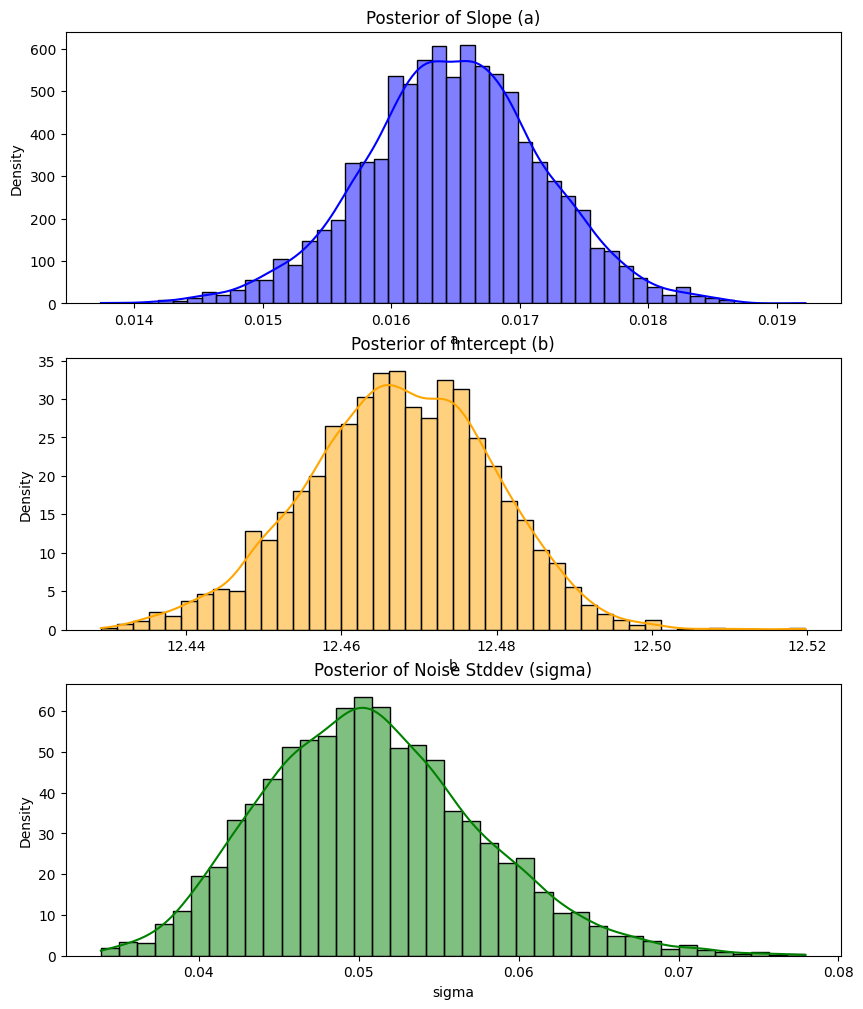

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=False)
sns.histplot(samples['a'], kde=True, ax=axes[0], color='blue', stat='density')
sns.histplot(samples['b'], kde=True, ax=axes[1], color='orange', stat='density')
sns.histplot(samples['sigma'], kde=True, ax=axes[2], color='green', stat='density')
axes[0].set_title('Posterior of Slope (a)')
axes[1].set_title('Posterior of Intercept (b)')
axes[2].set_title('Posterior of Noise Stddev (sigma)');

In [34]:
print(f"Posterior mean of slope (a): {samples['a'].mean():.3f} per year; 95% CI: {ci_a[0]:.3f} to {ci_a[1]:.3f}")
print(f"Posterior mean of slope (a): {10*samples['a'].mean():.3f} per decade.")

Posterior mean of slope (a): 0.016 per year; 95% CI: 0.015 to 0.018
Posterior mean of slope (a): 0.165 per decade.


#### Question: When will there be a two-hour marathon?
- A prediction problem!

In [35]:
xs = np.arange(-25, 50, .5)
y_pred = np.empty((len(samples), len(xs)))
for i, (slope, intercept, sigma) in enumerate(zip(samples['a'], samples['b'], samples['sigma'])):
    y_pred[i] = slope * xs + intercept + np.random.normal(0, sigma, len(xs))

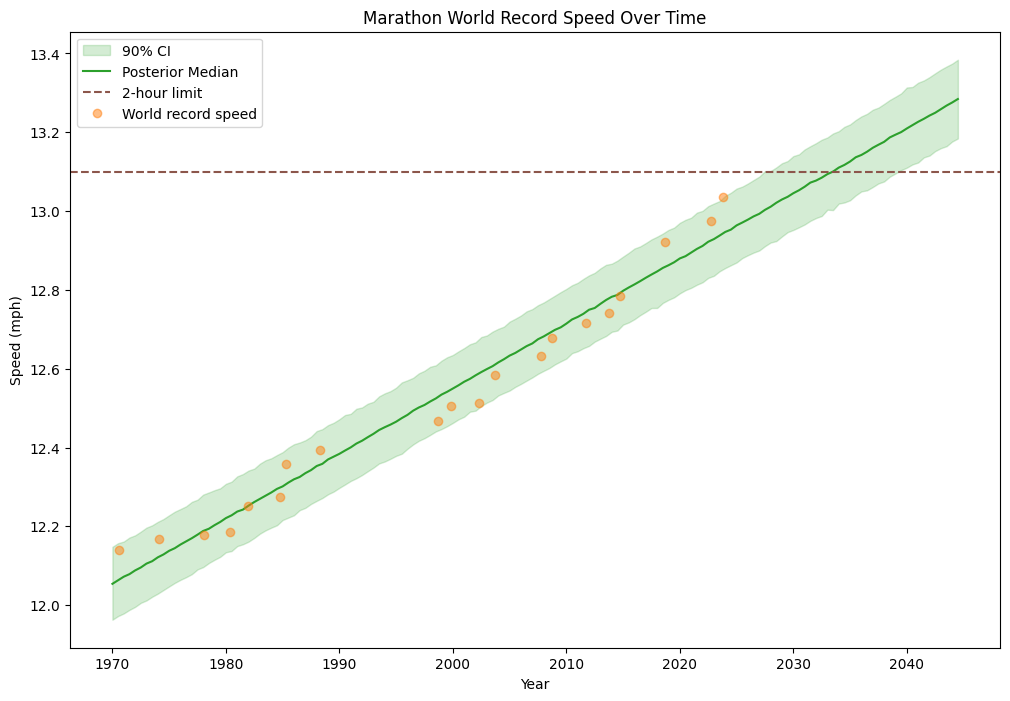

In [36]:
low, median, high = np.percentile(y_pred, [5, 50, 95], axis=0)
times = pd.to_timedelta(xs*365.25, unit='days') + offset  # Convert to timedelta
plt.figure(figsize=(12, 8))
plt.fill_between(times, low, high, color='C2', alpha=0.2, label='90% CI')
plt.plot(times, median, color='C2', label='Posterior Median')
plot_speeds(data)

In [37]:
times

DatetimeIndex(['1969-12-31 18:00:00', '1970-07-02 09:00:00',
               '1971-01-01 00:00:00', '1971-07-02 15:00:00',
               '1972-01-01 06:00:00', '1972-07-01 21:00:00',
               '1972-12-31 12:00:00', '1973-07-02 03:00:00',
               '1973-12-31 18:00:00', '1974-07-02 09:00:00',
               ...
               '2040-01-01 06:00:00', '2040-07-01 21:00:00',
               '2040-12-31 12:00:00', '2041-07-02 03:00:00',
               '2041-12-31 18:00:00', '2042-07-02 09:00:00',
               '2043-01-01 00:00:00', '2043-07-02 15:00:00',
               '2044-01-01 06:00:00', '2044-07-01 21:00:00'],
              dtype='datetime64[ns]', length=150, freq=None)

In [38]:
for i, (h, t) in enumerate(zip(high, times)):
    if h > two_hour_limit:
        print(f"Predicted year for sub-2-hour marathon: {t.year} {t.month} with speed {h:.2f} mph; {times[i-1]} with speed {h:.2f} mph")
        break
for m, t in zip(median, times):
    if m > two_hour_limit:
        print(f"Predicted year for sub-2-hour marathon: {t.year} with speed {m:.2f} mph")
        break
for l, t in zip(low, times):
    if l > two_hour_limit:
        print(f"Predicted year for sub-2-hour marathon: {t.year} with speed {l:.2f} mph")
        break

Predicted year for sub-2-hour marathon: 2027 7 with speed 13.10 mph; 2027-01-01 00:00:00 with speed 13.10 mph
Predicted year for sub-2-hour marathon: 2033 with speed 13.10 mph
Predicted year for sub-2-hour marathon: 2039 with speed 13.10 mph


In [39]:
# interpolation is done in speed-year space (not year-speed space)
from scipy.interpolate import interp1d
future = np.array([interp1d(high, xs)(13.1), interp1d(median, xs)(13.1), interp1d(low, xs)(13.1)])
dts = pd.to_timedelta(future*365.25, unit='days') + offset  # Convert to timedelta
pd.DataFrame(dict(datetime=dts), index=['early', 'median', 'late'])

,datetime
early,2027-06-16 21:14:49.355207554
median,2033-06-27 17:57:35.773384322
late,2039-04-11 10:31:40.979287986
